Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your github nickname below:

In [1]:
NICKNAME = "slava-qw"

---

# Часть 1. Гауссовы квадратуры

Метод Гауссовых квадратур является одним из методов численного интегрирования, который позволяет увеличить точность интегрирования, используя ортогональные полиномы и их корни в качестве узлов.

$$
\int_a^b \!  w(x)\, f(x)\, dx \approx \sum_{k=1}^n w_k \, f(x_k) \;,
$$

здесь $\omega$ - функция весов, которая определят базис ортогональных полиномов, чьи корни используются в качестве узлов интегрирования. 

Получаемая таким образом квадратурная схема *точно* инегрирует $f(x)$ если это полином степени $m\le2n-1$, где $n$ - степень полинома, корни которого используются в качестве узлов.

## Двухточечная квадратура Гаусса

Постройте квадратурную формулу Гаусса, интегрирующую точно многочлены степеней вплоть до третьей на интервале $[a, b]$. Заметим, что для этого достаточно построить _двухточечную_ квадратуру.

    hint:Легко найти точки и веса для отрезка [-1,1], после чего можно сделать аффинное преобразование..

Напишите функцию, которая возвращает веса, $w_1$ и $w_2$, и узлы, $x_1$ и $x_2$, двухточечной квадратурной формулы Гаусса с весовой функцией $w(x) = 1$, т.е., интегралы вида

$$
\int_a^b\! f(x)\, dx \approx w_1 f(x_1) + w_2 f(x_2)
$$

In [2]:
import scipy as sc
import numpy as np
import sympy as smp
from scipy.optimize import fsolve


def gauss_2(a, b):
    r"""Return nodes and weights for a two-point Gauss quadrature on [a, b].
    Use for this fsolve method form scipy.optimize or sympy library 
    
    Parameters
    ----------
    a, b : float
       Boundaries of the integration interval
       
    Returns
    -------
    x1, x2, w1, w2 : float
       Nodes and weights of the quadrature.
    """
    ans = lambda i: (b ** i - a ** i) / i
    def func(x):
      args = {'x1': x[0],
              'x2': x[1],
              'w1': x[2],
              'w2': x[3]}

      x = np.asarray([args['x1'], args['x2']])
      w = np.asarray([args['w1'], args['w2']])

      return [
              w.sum() - ans(1),
              (w * x).sum() - ans(2),
              (w * x ** 2).sum() - ans(3),
              (w * x ** 3).sum() - ans(4)
              ]

    x_and_w = fsolve(func, [a, a, b - a, b - a])
    return x_and_w
    

In [3]:
from numpy.testing import assert_allclose

x1, x2, w1, w2 = gauss_2(0, 1)

def f(x, n): 
    return x**n

for n in [0, 1, 2, 3]:
    assert_allclose(w1*f(x1, n=n) + w2*f(x2, n=n),
                    1./(n+1), atol=1e-14)

## Использование ортогональных полиномов

### Legendre

Теперь посчитаем следующий интеграл:

$$
\int_{-1}^1 (7x^3 - 8 x^2 - 3 x + 3) dx  \label{eq1}\tag{1}
$$

Здесь функция уже полиномиальна, поэтому возьмем весовую функцию $\omega(x) = 1$. Тогда вычисление интеграла сводится к сумме корней полинома, соответствующих весовой функции $\omega(x) = 1$. Например, здесь https://dlmf.nist.gov/18.3 вы можете увидеть, какой базис полиномов соответствует вашей весовой функции.

Заметим, что нашей соответствуют полиномы Лежандра. Теперь, зайдем в документацию https://docs.scipy.org/doc/scipy/reference/special.html#orthogonal-polynomials. Функция *roots_legendre* сразу же выдаст корни полиномов Лежандра, а также веса к их корням (для полиномов Лежандра все эти веса равны единице).

1. Посчитайте точное значение интеграла ([1](#mjx-eqn-eq1)) "руками".

In [4]:
F = lambda x: (7 / 4) * x ** 4 - (8 / 3) * x ** 3 - (3 / 2) * x ** 2 + 3 * x
real_ans = F(1) - F(-1)
real_ans

0.6666666666666674

2. Посчитайте значение интеграла ([1](#mjx-eqn-eq1)), используя обычный метод интегрирования на равномерной сетке (например, написанный вами в предыдущем дз). Оцените количество узлов, необходимых для достижения относительной точности $10^{-10}$.

In [5]:
def midpoint_method(func, a, b, n):
    h = (b - a) / n
    ans = 0.0
    xstart = a + 0.5 * h

    for i in range(n):
        ans += func(xstart + i * h)

    return ans * h

def trapezoid_method(func, a, b, delta, n=1):
    h = (b - a) / n
    bad_ans = 0.0
    better_ans = 0.5 * (func(a) + func(b))

    for i in range(1, n):
        better_ans += func(a + i * h)
    better_ans *= h
    
    error = max(1, abs(better_ans))
    while error > abs(delta * better_ans):
        bad_ans = better_ans
        better_ans = 0.5 * (better_ans + midpoint_method(func, a, b, n)) 

        n *= 2
        error = abs(better_ans - bad_ans)

    return better_ans, n + 1


f = lambda x: 7 * x ** 3 - 8 * x ** 2 - 3 * x + 3
ans, points_count = trapezoid_method(f, -1, 1, delta = 1e-10)
print(f'Результат численного вычисления методом трапеции {ans} при количестве узлов примерно равном: {points_count}')

Результат численного вычисления методом трапеции 0.6666666666569454 при количестве узлов примерно равном: 1048577


3. Посчитайте значение интеграла ([1](#mjx-eqn-eq1)), с помощью Гауссовой квадратуры (используя корни полинома Лежандра степени от 1 до 6 в качестве узлов) (чтобы получить корни и веса используйте scipy.special.roots_legendre)

In [6]:
from scipy.special import roots_legendre

f = lambda x: 7 * x ** 3 - 8 * x ** 2 - 3 * x + 3

print('-' * 60)
print('степень полинома Лежандра'.center(30), 'численный ответ'.center(29), sep='|')
print('-' * 60)

for i in range(1, 7):
    roots, weights = roots_legendre(i)

    ans = f(roots).dot(weights)
    print('-' * 60)
    print(f'{i}'.center(30), f'{ans}'.center(29), sep='|')
    
print('-' * 60)

------------------------------------------------------------
  степень полинома Лежандра   |       численный ответ       
------------------------------------------------------------
------------------------------------------------------------
              1               |             6.0             
------------------------------------------------------------
              2               |      0.6666666666666674     
------------------------------------------------------------
              3               |      0.6666666666666639     
------------------------------------------------------------
              4               |      0.6666666666666667     
------------------------------------------------------------
              5               |      0.6666666666666685     
------------------------------------------------------------
              6               |      0.6666666666666695     
------------------------------------------------------------


Сравните количество узлов, необходимых для достижения одинаковой точности в обоих численных методах.

In [7]:
from scipy.special import roots_legendre


def quad_legendre(f, delta):
    ans = 1000
    i = 0
    while abs(ans - 2/3) > 2/3 * delta:
        i += 1
        roots, weights = roots_legendre(i)
        ans = f(roots).dot(weights)

    return ans, i
    
f = lambda x: 7 * x ** 3 - 8 * x ** 2 - 3 * x + 3


print('-' * 60)
print('точность'.center(30), 'количество узлов'.center(29), sep='|')
print(''.center(30), 'метод Гаусса'.center(14), 'метод трапеции'.center(14), sep='|')
print('-' * 60)

for i in range(1, 13):
    print('-' * 60)

    ans_gq, points_count_gq = quad_legendre(f, delta = 10 **(-i))
    ans_tr, points_count_tr = trapezoid_method(f, -1, 1, delta = 10 **(-i))
    print(f'1e-{i}'.center(30), f'{points_count_gq}'.center(14), f'{points_count_tr}'.center(14), sep='|')


------------------------------------------------------------
           точность           |       количество узлов      
                              | метод Гаусса |метод трапеции
------------------------------------------------------------
------------------------------------------------------------
             1e-1             |      2       |      33      
------------------------------------------------------------
             1e-2             |      2       |     129      
------------------------------------------------------------
             1e-3             |      2       |     257      
------------------------------------------------------------
             1e-4             |      2       |     1025     
------------------------------------------------------------
             1e-5             |      2       |     4097     
------------------------------------------------------------
             1e-6             |      2       |     8193     
------------------------


Вычислите значение того же интеграла, но на интервале от 0 до 10.

$$
\int_{0}^{10} (7x^3 - 8 x^2 - 3 x + 3) dx 
$$

Заметим, что больше нельзя использовать полиномы Лежанда, потому что они определены на интервале (-1, 1). Однако всегда можно произвести *аффинное преобразование* для того, чтобы перейти к желаемой системе координат.

(20% итоговой оценки)

In [8]:
a = 0
b = 10
f = lambda x: 7 * x ** 3 - 8 * x ** 2 - 3 * x + 3

roots, weights = roots_legendre(6)
t = (b - a) / 2 * roots + (a + b) / 2
ans = (b - a) / 2 * f(t).dot(weights)
print(f'Результат численного интегрирования методом Гауссовых квадратур: {ans}')

Результат численного интегрирования методом Гауссовых квадратур: 14713.333333333336


Сравните результат с точным значением интеграла.

$$
\int \limits_{0}^{10} (7x^3 - 8 x^2 - 3 x + 3) dx = \left(\frac{7}{4} x^4 - \frac{8}{3} x^3 - \frac{3}{2} x^2 + x \right)\Bigg|_0^{10} = \frac{14713}{3}
$$

Как видно, численный ответ с хорошей точностью равен реальному.

### 

Вычислите значение следующиего интеграла:
$$
\int \limits_{0}^{2\pi} \frac{cos(x) dx }{\sqrt{4\pi^2 - x^2}} = \bigg / y = \frac{x}{2\pi} \bigg / = \int \limits_{0}^{1} \frac{cos(2\pi y) dy }{\sqrt{1 - y^2}} = \frac{1}{2} \int \limits_{-1}^{1} \frac{cos(2\pi y) dy }{\sqrt{1 - y^2}}
$$
используя соответствующий базис ортогональных полиномов.
Найдите степень полинома (количество узлов), при которой точность превысит машинное $\epsilon$.


In [9]:
# as we can see above, we should use Chebyshev of first kind polynomial

from scipy.special import roots_chebyt
import numpy as np

f = lambda y: np.cos(2 * np.pi * y)
eps = 1e-16
real_ans = 0.34601015881226444
ans = 10000
i = 1

while abs(ans - real_ans) >= eps:
    roots, weights = roots_chebyt(i)
    ans = 0.5 * f(roots).dot(weights)
    i += 1
print(f'Степень полинома Чебышева, обеспечивающая машинную точность (1e-16) равна {i}, при этом результат равен: {ans}')

Степень полинома Чебышева, обеспечивающая машинную точность (1e-16) равна 17, при этом результат равен: 0.3460101588122644


# Часть 2. Уравение Фредгольма

Существует два типа уравнений Фредгольма: 

1. Уравение Фредгольма первого рода:
$$
\int_a^b \! K(x, t)\, \color{blue}{f(t)} \,dt = g(x)
$$

2. Уравнение Фредгольма второго рода:
$$
\lambda \int_a^b\! K(x, t)\, \color{blue}{f(t)} \, dt + g(x) = \color{blue}{f(x)}
$$

Здесь функция $f(x)$ неизвестна, $K(x, t)$ - ядро уравнения, заданная функция $g(x)$ и $\lambda$ - рациональное число.
С точки зрения вычислений, уравение Фредгольма первого рода крайне неустойчиво. Далее мы рассмотрим только уравнение второго рода.

Основная идея - аппроксимировать интеграл некой квадратурной формулой

$$
\int_a^b \! \xi(t)\, dt \approx \sum_j^N w_j\, \xi(t_j)
$$

с подходящими весами $w_j$ и узлами $t_j$, $j=1, \dots, N$. Точность аппроксимации контролируется $N$.

Таким образом, уравнение Фредгольма приближается следующим образом:

$$
\lambda \sum_j w_j\, K(x, t_j)\, \color{blue}{f(t_j)} + g(x) = \color{blue}{f(x)}
$$

Отметим, что $x$ - непрерывная переменная, в то время, как $t$ - дискретная.

Рассматривая данное уравнение на тех же узлах сетки $x = t_k$, получаем

$$
\lambda \sum_j w_j \, K_{k, j}\, \color{blue}{f_j} + g_k = \color{blue}{f_k}
$$

где $f_j \equiv f(t_j)$, $g_j \equiv g(t_j)$ and $K_{k, j} \equiv K(t_k, t_j)$. Это ничто иное, как система линейных алгебраических уравнений на вектор $\color{blue}{f_j}$.

Ее решение выдает значение неизвестной функции $f(x)$ в дискретных точках $x=t_j$ для $j=1, \dots, N$.


Решите предложенное уравнение Фредгольма второго рода

$$
f(x) = \cos(x)  + \frac{1}{2\pi} \int_0^\pi \! \sin(x) \,t f(t) \, dt
$$

Здесь $a, b = 0, \pi$, $\lambda = \dfrac{1}{2\pi}$, ядро $K(x, t) = \sin(x)\cdot t$ и правая часть - $g(x) = \cos(x)$.

Точное решение (Сборник задач по интегральным уравнениям, 2006):

$$
f(x) = \cos(x)- \frac{2}{\pi}\sin(x)
$$

Вывод формулы численного решения:

Сделаем замену переенной $\hat{y} = \frac{t}{\pi}, \ \hat{x} = \frac{x}{\pi}$:

$$
f(\pi \hat x) = \cos(\pi \hat x)  + \frac{\pi}{2} \int \limits_0^1 \! \sin(\pi \hat x) \, \hat y f(\pi \hat y) \, d\hat y
$$

Пусть $f(\pi \hat x) \equiv \hat f(\hat x), \, \cos(\pi \hat x) \equiv \hat g(\hat x), \, \sin(\pi \hat x) \hat y \equiv \hat K(\hat x, \hat y)$, тогда полученное уравнение можно переписать как:

$$
\hat f(\hat x) = \hat g(\hat x)  + \frac{\pi}{2} \int \limits_0^1 \! \hat K(\hat x, \hat y) \hat f(\hat y) \, d\hat y
$$

Опустим крышечки у переменных и функций (для удобства и краткости):

$$
f(x) = g(x)  + \frac{\pi}{2} \int \limits_0^1 \! K(x, y) f( y) \, dy
$$

Это уравнение уже можно приблизить с помощью квадратур Гаусса (используя для этого сдвинутый полином Лежандра). Тогда для приближенного решения:

$$
\lambda \sum_j w_j \, K_{k, j}\, \color{blue}{f_j} + g_k = \color{blue}{ f_k}
$$

Для нашего случая весовая функции $\omega(x) = 1, \ \lambda = \frac{\pi}{2}$, также будем считать что $k=1, \dots, N$, поэтому:

$$
\lambda \sum_{j = 1}^N w_j \,  K_{k, j}\, \color{blue}{f_j} + g_k = \color{blue}{f_k} \iff  \sum_{j = 1}^N \left( \lambda w_j\, K_{k, j} \,  - \, \delta_{jk} \right) \color{blue}{f_j}= - g_k
$$

Такая запись эквивалентна следующему матричному уравнению:

$$
    \begin{pmatrix}
        \lambda w_j K(t_1, t_1) - 1 & \lambda w_j K(t_1, t_2) & \dots & \lambda w_j K(t_1, t_N)\\
        \lambda w_j K(t_2, t_1) & \lambda w_j K(t_2, t_2) - 1 & \dots & \lambda w_j K(t_2, t_N)\\ 
        \vdots & \vdots & \ddots & \vdots\\ 
        \lambda w_j K(t_N, t_1) & \lambda w_j K(t_N, t_2) & \dots & \lambda w_j K(t_N, t_N) - 1 
    \end{pmatrix}
    \times
    \begin{pmatrix}
        f(t_1) \\
        f(t_2) \\ 
        \vdots \\ 
        f(t_N)
    \end{pmatrix}
    =
    \begin{pmatrix}
        - g(t_1) \\
        - g(t_2) \\ 
        \vdots \\ 
        - g(t_N)
    \end{pmatrix}
$$
  
Решая эту СЛАУ, мы найдём значения функции $f$ в точках $t_j, \ j = 1, \dots, N$, где $t_j$ - корни сдвинутого многочлена Лежандра.

Не забываем, что мы нашли значения функции $f$ в точках $\hat x = \pi t_j$

Для нахождения интеграла преобразуйте заменой переменных в интеграле область интегрирования в [0,1] воспользуйтесь Гауссовой квадратурой с весовой функцией $w(x) = 1$ на $(0, 1)$. Посмотрите на http://dlmf.nist.gov/18.3, и найдите соответствующую функцию в *scipy.special* (обратите внимание на область интегрирования).

Напишите функцию, возвращающую значение f(t_j) по схеме выше, которая в качестве параметра принимает величину $N$--число узлов в квадратуре, для нахождение решения СЛАУ можно использовать `scipy.linalg.solve`.

Постройте график истинного решения и набор (t_j, f_j) для различных $N$, используя вашу функцию.

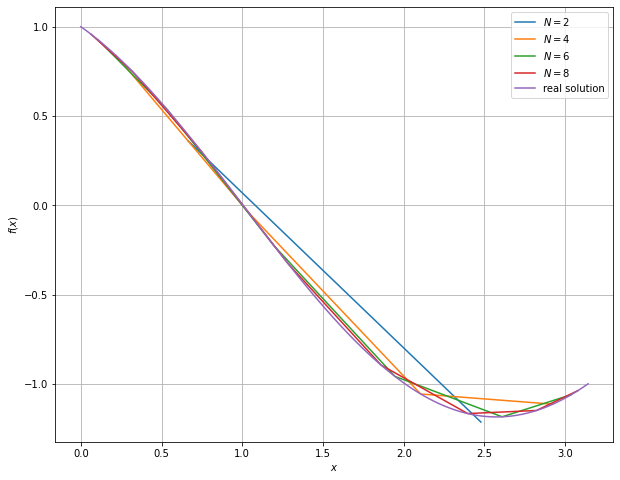

In [10]:
from scipy.special import roots_sh_legendre
from scipy.linalg import solve
import matplotlib.pyplot as plt
import numpy as np


def returner(N):
    roots, weights = roots_sh_legendre(N)
    l = np.pi * 0.5

    K = lambda t_k, t_j: np.sin(np.pi * t_k) * t_j
    g = lambda x: np.cos(np.pi * x)

    I = np.eye(N)

    matrix_K = l * np.asarray([weights * K(t_k, roots) for t_k in roots]) - I
    matrix_minus_g = - g(roots)

    f = solve(matrix_K, matrix_minus_g)

    return f


plt.figure(figsize=(10, 8))
plt.grid(True)
plt.xlabel(r'$x$')
plt.ylabel(r'$f(x)$')


for N in range(2, 10, 2):
    roots, weights = roots_sh_legendre(N)

    x = roots * np.pi
    f = returner(N)

    plt.plot(x, f, label=f'$N = {N}$')


real_f = lambda x: np.cos(x) - (2 / np.pi) * np.sin(x)
x = np.linspace(0, np.pi, 100)
plt.plot(x, real_f(x), label='real solution')
plt.legend(loc="best")
plt.show()

Очевидной проблемой предыдущего результата для $f(x)$ является то, что он возвращает решения на фиксированном наборе точек. Мы не контролируем их расположение.

Оказывается, интерполяционные методы (мы обсудим их на следующих занятиях) работают не очень хорошо, в сравнении с следующим подходом:

Используйте изначальный вид, чтобы вычислить значение функции на всём интервале:

$$
f(x) = g(x) + \lambda \sum_j^N w_j\, K(x, t_j)\, f(t_j)
$$

Сравните эту интерполяцию с точным решением для разлиных $N$.
(выбирайте наглядный масштаб)

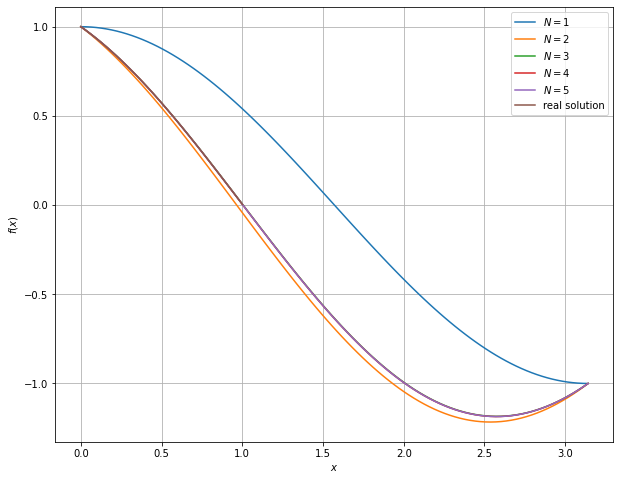

In [16]:
plt.figure(figsize=(10, 8))
plt.grid(True)
plt.xlabel(r'$x$')
plt.ylabel(r'$f(x)$')

K = lambda t_k, t_j: np.sin(np.pi * t_k) * t_j
g = lambda x: np.cos(np.pi * x)
x = np.linspace(0, 1, 100)
l = 0.5 * np.pi 

for N in range(1, 6):
    roots, weights = roots_sh_legendre(N)
    hat_f = returner(N)

    f = lambda x: g(x) + l * (weights * K(x, roots) * hat_f).sum()
    result_f = np.asarray([f(y) for y in x])

    plt.plot(x * np.pi, result_f, label=f'$N = {N}$')


real_f = lambda x: np.cos(x) - (2 / np.pi) * np.sin(x)
plt.plot(x, real_f(x), label='real solution')
plt.legend(loc="best")
plt.show()

# Часть 3. Интеграл от осциллирующей функции - EXTRA points task

Рассмотрим определенный интеграл

$$
I = \int_0^\infty\! \frac{\sin(x) \cos{(\cos{(x)})}}{x}\,dx
$$

Вычислите значение данного интеграла с относительной точностью $10^{-6}$. Для упрощения задачи можете воспользоваться функционалом `scipy.integrate.quad`.

Заметим, что "из коробки" интеграл вычислить не удается, и нужно что-то придумать.

In [12]:
from math import sin, cos, tan, pi, e
from scipy.integrate import quad

real_ans = 1.18635
f = lambda x: sin(x) * cos(cos(x)) / x

f_tg = lambda u: f(tan(u)) / cos(u) ** 2 # this one only gives 1e-1 accuracy
f_t = lambda t: f(0 + t / (1 - t)) / (1 - t) ** 2 # this one only gives 1e-1 accuracy


my_ans_0, error_0 = quad(f, 0, float("inf"))
my_ans_1, error_1 = quad(f_tg, 0, 0.5 * pi)
my_ans_2, error_2 = quad(f_t, 0, 1, points=[0, 1])

print(my_ans_0, error_0, abs(my_ans_0 - real_ans) / real_ans)
print(my_ans_1, error_1, abs(my_ans_1 - real_ans) / real_ans)
print(my_ans_2, error_1, abs(my_ans_2 - real_ans) / real_ans)

1.9653912540956746 4.089174284042278 0.6566706739964383
2.3575465543065146 1.379027038596143 0.9872268338235045
1.8438974131435086 1.379027038596143 0.5542608953036697


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  del sys.path[0]


Напишите функцию, которая возвращает значение данного интеграла. Только само значение интеграла, без оценки погрешности.
(оборачиваем интеграл в функцию только для удобства автопроверки).

In [13]:
# Maybe following links will help...
# see here: https://www.sciencedirect.com/science/article/pii/S0377042706005929#fd7
# or: https://docs.yandex.ru/docs/view?tm=1668682059&tld=ru&lang=en&name=1912.09698.pdf&text=he%20Filon%20and%20Levin%20methods%20for%20highly%20oscillatory%20integral&url=https%3A%2F%2Farxiv.org%2Fpdf%2F1912.09698.pdf&lr=213&mime=pdf&l10n=ru&sign=5c7895c18d19c8f669d754c21a8bd9d8&keyno=0&nosw=1&serpParams=tm%3D1668682059%26tld%3Dru%26lang%3Den%26name%3D1912.09698.pdf%26text%3Dhe%2BFilon%2Band%2BLevin%2Bmethods%2Bfor%2Bhighly%2Boscillatory%2Bintegral%26url%3Dhttps%253A%2F%2Farxiv.org%2Fpdf%2F1912.09698.pdf%26lr%3D213%26mime%3Dpdf%26l10n%3Dru%26sign%3D5c7895c18d19c8f669d754c21a8bd9d8%26keyno%3D0%26nosw%3D1
# or use Laplace Transforms

from scipy.integrate import quad

def integ():
    """Return a single float, the computed value of the integral."""
    # YOUR CODE HERE
    raise NotImplementedError()

In [14]:
from numpy.testing import assert_allclose

# this is a test cell, keep it intact
